In [55]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten)
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, roc_curve, auc, precision_score, recall_score)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input

from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [44]:
def show_sample_images(generator, class_names, num_images=5):
    # Get batch of images and labels
    images, labels = next(generator)
    plt.figure(figsize=(15,5))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        image = images[index]
        label = labels[index]
        if generator.class_mode == 'categorical':
            label_index = np.argmax(label)
            label_name = class_names[label_index]
        else:
            label_name = class_names[int(label)]
        plt.subplot(1, num_images, i+1)
        plt.imshow(image)
        plt.title(f'Label: {label_name}')
        plt.axis('off')
    plt.show()



In [67]:


# Define paths
TRAIN_DIR_FAST = '../Data/processed/dataset2_processed/train/'
VALIDATION_DIR_FAST = '../Data/processed/dataset2_processed/test/'

TRAIN_DIR_ACCURATE = '../Data/processed/dataset1/train/'
VALIDATION_DIR_ACCURATE = '../Data/processed/dataset1/test/'

MODELS_DIR = '../models/'
os.makedirs(MODELS_DIR, exist_ok=True)

OUTPUT_CONFUSION_MATRICES_DIR = '../output/confusion_matrices/'
os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)

OUTPUT_EVALUATION_METRICS_DIR = '../output/evaluation_metrics/'
os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)

def fast_model():
    # Fast Model - Binary Classification
    print("Training Fast Model...")

    # Data generators for Fast Model
    train_datagen_fast = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, zoom_range=0.2)
    validation_datagen_fast = ImageDataGenerator(rescale=1./255)

    train_generator_fast = train_datagen_fast.flow_from_directory(
        TRAIN_DIR_FAST, target_size=(224, 224), batch_size=32, class_mode='binary')

    validation_generator_fast = validation_datagen_fast.flow_from_directory(
        VALIDATION_DIR_FAST, target_size=(224, 224), batch_size=32, class_mode='binary', shuffle=False)

    # Define Fast Model architecture
    model_fast = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])

    model_fast.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping_fast = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_fast = ModelCheckpoint(
        '../models/model_fast.h5', save_best_only=True)

    # Train Fast Model
    history_fast = model_fast.fit(
        train_generator_fast,
        epochs=30,
        validation_data=validation_generator_fast,
        callbacks=[early_stopping_fast, checkpoint_fast]
    )

    # Create output directories for this model
    MODEL_NAME = 'fast_model'
    OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
    os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
    OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
    os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)

    # Evaluate Fast Model
    print("Evaluating Fast Model...")
    # Get true labels and predictions
    validation_generator_fast.reset()
    Y_true = validation_generator_fast.classes
    Y_pred_prob = model_fast.predict(validation_generator_fast, verbose=1)
    Y_pred = (Y_pred_prob > 0.5).astype('int32').reshape(-1)

    # Calculate evaluation accuracy
    evaluation_metrics = model_fast.evaluate(validation_generator_fast, verbose=1)
    evaluation_loss = evaluation_metrics[0]
    evaluation_accuracy = evaluation_metrics[1]
    print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")

    # Calculate F1 Score, Precision, Recall
    f1 = f1_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Classification Report
    target_names = list(validation_generator_fast.class_indices.keys())
    print("Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_names))

    # Confusion Matrix with Percentages
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percentage = np.nan_to_num(cm_percentage)

    # Prepare annotations with percentage symbol
    annot_labels = np.empty_like(cm_percentage).astype(str)
    nrows, ncols = cm_percentage.shape
    for i in range(nrows):
        for j in range(ncols):
            annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Percentage) - Fast Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Save confusion matrix
    confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
    plt.savefig(confusion_matrix_path)
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Fast Model')
    plt.legend(loc='lower right')
    # Save ROC curve
    roc_curve_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'roc_curve.png')
    plt.savefig(roc_curve_path)
    plt.show()

    # Save evaluation metrics to CSV
    metrics_data = {
        'Metric': ['Validation Accuracy', 'Validation Loss', 'F1 Score', 'Precision', 'Recall', 'AUC'],
        'Value': [evaluation_accuracy, evaluation_loss, f1, precision, recall, roc_auc]
    }
    metrics_df = pd.DataFrame(metrics_data)
    metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save the final model
    model_fast.save('../models/model_fast_final.h5')


def accurate_model():
    print("Training Accurate Model...")

    from sklearn.preprocessing import label_binarize

    # Data generators for Accurate Model
    train_datagen_accurate = ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, rotation_range=20
        )
    validation_datagen_accurate = ImageDataGenerator(rescale=1./255)

    train_generator_accurate = train_datagen_accurate.flow_from_directory(
        TRAIN_DIR_ACCURATE,
        target_size = (224,224),
        class_mode = 'categorical',
        shuffle = True,
        batch_size = 32,
        color_mode = 'rgb',
        x_col = 'pth',
        y_col = 'label'
        # subset = 'training'
    )

    validation_generator_accurate = validation_datagen_accurate.flow_from_directory(
        VALIDATION_DIR_ACCURATE,
        target_size = (224,224),
        class_mode = 'categorical',
        shuffle = False,
        batch_size = 32,
        color_mode = 'rgb',
        x_col = 'pth',
        y_col = 'label',    
          )

    # Get class names
    target_names = list(validation_generator_accurate.class_indices.keys())

    # Define Accurate Model architecture using ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model_accurate = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(target_names), activation='softmax')  # Number of classes
    ])

    model_accurate.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping_accurate = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_accurate = ModelCheckpoint(
        '../models/model_accurate.h5', save_best_only=True)

    # Train Accurate Model
    history_accurate = model_accurate.fit(
        train_generator_accurate,
        epochs=30,
        validation_data=validation_generator_accurate,
        callbacks=[early_stopping_accurate, checkpoint_accurate]
    )

    # Create output directories for this model
    MODEL_NAME = 'accurate_model'
    OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
    os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
    OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
    os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)

    # Evaluate Accurate Model
    print("Evaluating Accurate Model...")
    validation_generator_accurate.reset()
    Y_true = validation_generator_accurate.classes
    Y_pred_prob = model_accurate.predict(validation_generator_accurate, verbose=1)
    Y_pred = np.argmax(Y_pred_prob, axis=1)

    # Calculate evaluation accuracy
    evaluation_metrics = model_accurate.evaluate(validation_generator_accurate, verbose=1)
    evaluation_loss = evaluation_metrics[0]
    evaluation_accuracy = evaluation_metrics[1]
    print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")

    # Calculate F1 Score, Precision, Recall
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_names))

    # Confusion Matrix with Percentages
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percentage = np.nan_to_num(cm_percentage)

    # Prepare annotations with percentage symbol
    annot_labels = np.empty_like(cm_percentage).astype(str)
    nrows, ncols = cm_percentage.shape
    for i in range(nrows):
        for j in range(ncols):
            annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Percentage) - Accurate Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Save confusion matrix
    confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
    plt.savefig(confusion_matrix_path)
    plt.show()

    # ROC Curves for each class
    Y_true_binarized = label_binarize(Y_true, classes=range(len(target_names)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = {:.4f})'.format(roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Class: {target_names[i]}')
        plt.legend(loc='lower right')
        # Save ROC curve for each class
        roc_curve_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, f'roc_curve_{target_names[i]}.png')
        plt.savefig(roc_curve_path)
        plt.close()

    # Save evaluation metrics to CSV
    metrics_data = {
        'Metric': ['Validation Accuracy', 'Validation Loss', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
        'Value': [evaluation_accuracy, evaluation_loss, f1, precision, recall]
    }
    metrics_df = pd.DataFrame(metrics_data)
    metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save the final model
    model_accurate.save('../models/model_accurate_final.h5')




def accurate_model_2():
    print("Training Accurate Model 2 using MobileNetV2...")

    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from sklearn.preprocessing import label_binarize

    # Data generators for Accurate Model 2
    train_datagen_accurate = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        horizontal_flip=True,
        rotation_range=20)
    validation_datagen_accurate = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator_accurate = train_datagen_accurate.flow_from_directory(
        TRAIN_DIR_ACCURATE, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)

    validation_generator_accurate = validation_datagen_accurate.flow_from_directory(
        VALIDATION_DIR_ACCURATE, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

    # Get class names
    target_names = list(validation_generator_accurate.class_indices.keys())

    # Define Accurate Model 2 architecture using MobileNetV2
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    model_accurate_2 = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(target_names), activation='softmax')  # Number of classes
    ])

    model_accurate_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping_accurate_2 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint_accurate_2 = ModelCheckpoint(
        '../models/model_accurate_2.h5', save_best_only=True)

    # Train Accurate Model 2
    history_accurate_2 = model_accurate_2.fit(
        train_generator_accurate,
        epochs=30,
        validation_data=validation_generator_accurate,
        callbacks=[early_stopping_accurate_2, checkpoint_accurate_2]
    )

    # Create output directories for this model
    MODEL_NAME = 'accurate_model_2'
    OUTPUT_CONFUSION_MATRICES_DIR = os.path.join('../output/confusion_matrices/', MODEL_NAME)
    os.makedirs(OUTPUT_CONFUSION_MATRICES_DIR, exist_ok=True)
    OUTPUT_EVALUATION_METRICS_DIR = os.path.join('../output/evaluation_metrics/', MODEL_NAME)
    os.makedirs(OUTPUT_EVALUATION_METRICS_DIR, exist_ok=True)

    # Evaluate Accurate Model 2
    print("Evaluating Accurate Model 2...")
    validation_generator_accurate.reset()
    Y_true = validation_generator_accurate.classes
    Y_pred_prob = model_accurate_2.predict(validation_generator_accurate, verbose=1)
    Y_pred = np.argmax(Y_pred_prob, axis=1)

    # Calculate evaluation accuracy
    evaluation_metrics = model_accurate_2.evaluate(validation_generator_accurate, verbose=1)
    evaluation_loss = evaluation_metrics[0]
    evaluation_accuracy = evaluation_metrics[1]
    print(f"Validation Accuracy: {evaluation_accuracy*100:.2f}%")

    # Calculate F1 Score, Precision, Recall
    f1 = f1_score(Y_true, Y_pred, average='weighted')
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(Y_true, Y_pred, target_names=target_names))

    # Confusion Matrix with Percentages
    cm = confusion_matrix(Y_true, Y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    cm_percentage = np.nan_to_num(cm_percentage)

    # Prepare annotations with percentage symbol
    annot_labels = np.empty_like(cm_percentage).astype(str)
    nrows, ncols = cm_percentage.shape
    for i in range(nrows):
        for j in range(ncols):
            annot_labels[i, j] = f'{cm_percentage[i, j]:.2f}%'

    plt.figure(figsize=(10,8))
    sns.heatmap(cm_percentage, annot=annot_labels, fmt='', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Percentage) - Accurate Model 2 (MobileNetV2)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # Save confusion matrix
    confusion_matrix_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, 'confusion_matrix_percentage.png')
    plt.savefig(confusion_matrix_path)
    plt.show()

    # ROC Curves for each class
    Y_true_binarized = label_binarize(Y_true, classes=range(len(target_names)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(target_names)):
        fpr[i], tpr[i], _ = roc_curve(Y_true_binarized[:, i], Y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = {:.4f})'.format(roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Class: {target_names[i]}')
        plt.legend(loc='lower right')
        # Save ROC curve for each class
        roc_curve_path = os.path.join(OUTPUT_CONFUSION_MATRICES_DIR, f'roc_curve_{target_names[i]}.png')
        plt.savefig(roc_curve_path)
        plt.close()

    # Save evaluation metrics to CSV
    metrics_data = {
        'Metric': ['Validation Accuracy', 'Validation Loss', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall'],
        'Value': [evaluation_accuracy, evaluation_loss, f1, precision, recall]
    }
    metrics_df = pd.DataFrame(metrics_data)
    metrics_csv_path = os.path.join(OUTPUT_EVALUATION_METRICS_DIR, 'metrics.csv')
    metrics_df.to_csv(metrics_csv_path, index=False)

    # Save the final model
    model_accurate_2.save('../models/model_accurate_2_final.h5')

# 

Training Fast Model...
Found 336 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Epoch 1/30
11/11 [==============================] - 12s 999ms/step - loss: 2.0500 - accuracy: 0.5268 - val_loss: 0.6894 - val_accuracy: 0.4825
Epoch 2/30
11/11 [==============================] - 10s 940ms/step - loss: 0.5708 - accuracy: 0.7262 - val_loss: 0.5504 - val_accuracy: 0.7193
Epoch 3/30
11/11 [==============================] - 11s 1s/step - loss: 0.5144 - accuracy: 0.7917 - val_loss: 0.5039 - val_accuracy: 0.7807
Epoch 4/30
11/11 [==============================] - 11s 1s/step - loss: 0.4690 - accuracy: 0.8125 - val_loss: 0.4974 - val_accuracy: 0.7807
Epoch 5/30
11/11 [==============================] - 8s 649ms/step - loss: 0.4558 - accuracy: 0.8065 - val_loss: 0.5826 - val_accuracy: 0.7368
Epoch 6/30
11/11 [==============================] - 8s 759ms/step - loss: 0.4137 - accuracy: 0.8274 - val_loss: 0.5083 - val_accuracy: 0.7982
Epoch 7/30
11/11 [===========================

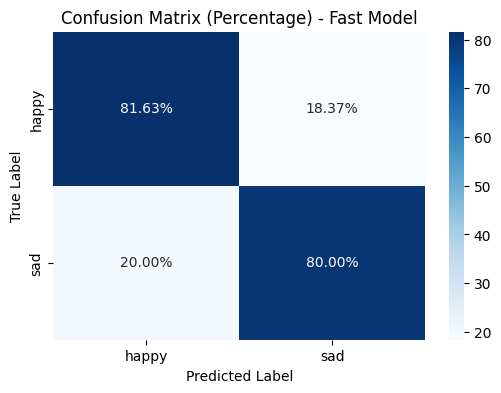

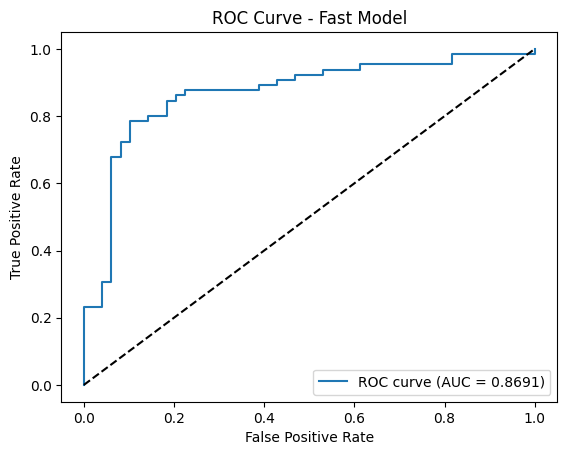

In [50]:
fast_model()

Training Accurate Model...
Found 23229 images belonging to 8 classes.
Found 5813 images belonging to 8 classes.
Epoch 1/30
726/726 [==============================] - 196s 265ms/step - loss: 2.2919 - accuracy: 0.1417 - val_loss: 2.0561 - val_accuracy: 0.1390
Epoch 2/30
726/726 [==============================] - 187s 257ms/step - loss: 2.0810 - accuracy: 0.1589 - val_loss: 2.0697 - val_accuracy: 0.1390
Epoch 3/30
726/726 [==============================] - 182s 250ms/step - loss: 1.8796 - accuracy: 0.2326 - val_loss: 2.1080 - val_accuracy: 0.1624
Epoch 4/30
726/726 [==============================] - 187s 257ms/step - loss: 1.6537 - accuracy: 0.2651 - val_loss: 2.1252 - val_accuracy: 0.1326
Epoch 5/30
726/726 [==============================] - 188s 258ms/step - loss: 1.6232 - accuracy: 0.2734 - val_loss: 2.0940 - val_accuracy: 0.1467
Epoch 6/30
726/726 [==============================] - 186s 256ms/step - loss: 1.6172 - accuracy: 0.2790 - val_loss: 1.9013 - val_accuracy: 0.1701
Epoch 7/30
7

/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

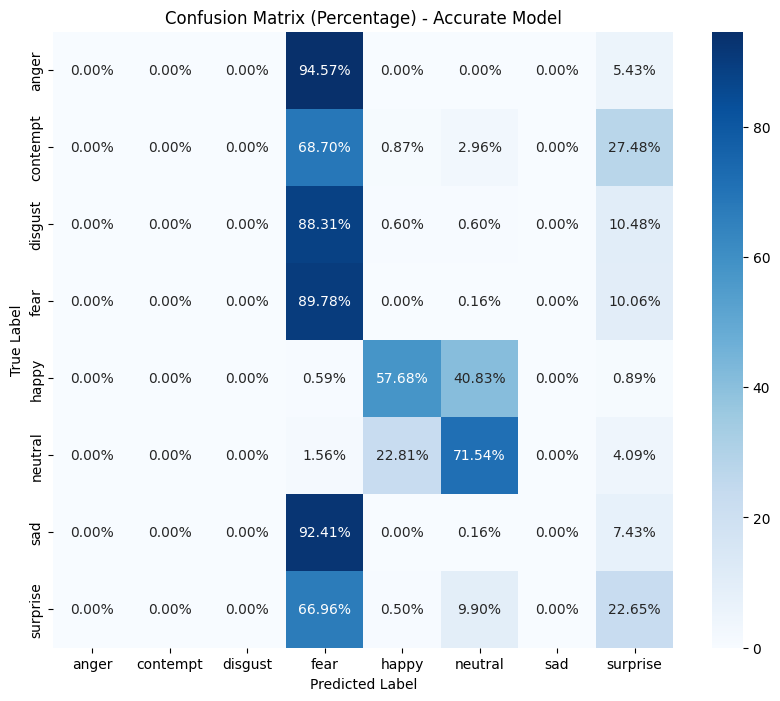

In [63]:
accurate_model()

Training Accurate Model 2 using MobileNetV2...
Found 23229 images belonging to 8 classes.
Found 5813 images belonging to 8 classes.
Epoch 1/30
726/726 [==============================] - 187s 253ms/step - loss: 2.2962 - accuracy: 0.1447 - val_loss: 2.0523 - val_accuracy: 0.1762
Epoch 2/30
726/726 [==============================] - 181s 249ms/step - loss: 2.0844 - accuracy: 0.1658 - val_loss: 2.0479 - val_accuracy: 0.1736
Epoch 3/30
726/726 [==============================] - 182s 250ms/step - loss: 2.0592 - accuracy: 0.1710 - val_loss: 2.0491 - val_accuracy: 0.1736
Epoch 4/30
726/726 [==============================] - 183s 252ms/step - loss: 2.0537 - accuracy: 0.1698 - val_loss: 2.0512 - val_accuracy: 0.1736
Epoch 5/30
726/726 [==============================] - 183s 252ms/step - loss: 1.9332 - accuracy: 0.2136 - val_loss: 2.0122 - val_accuracy: 0.1729
Epoch 6/30
726/726 [==============================] - 176s 242ms/step - loss: 1.7067 - accuracy: 0.2554 - val_loss: 1.9055 - val_accuracy:

/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/abdo/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

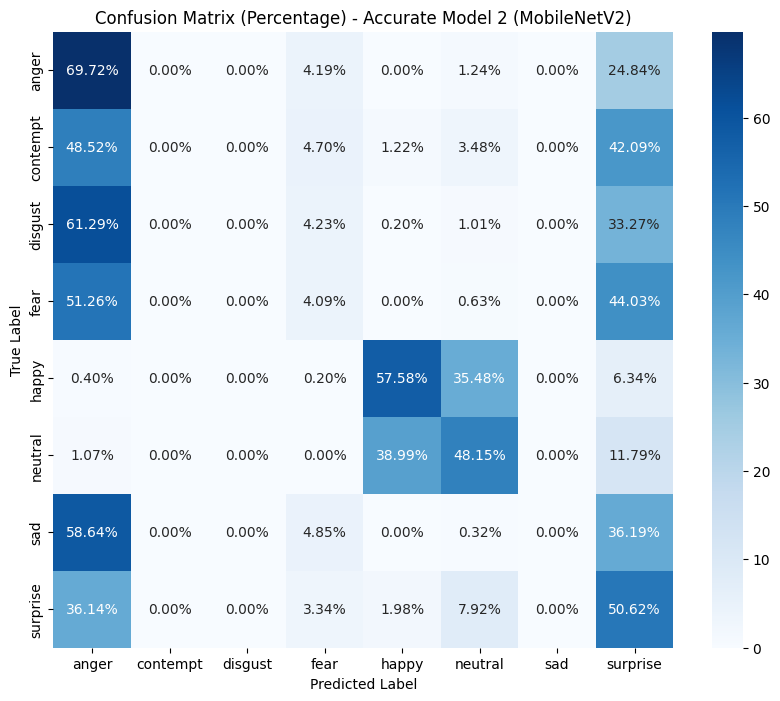

In [62]:
accurate_model_2()